# Cluster Style Dimensions

In [1]:
import numpy as np
import pandas as pd
from plotnine import *
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

import sys
import os
import yaml

In [2]:
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

In [3]:
response_db = pd.read_csv("../data/sim_params/prompt_db_20dim.csv.gzip", compression="gzip")

In [4]:
dims = ["optimism", "formality", "severity", "clarity", "encouragement", "actionability", 
"complexity", "supportiveness", "authenticity","conciseness", "female-codedness", 
"personalization", "threat", "authoritativeness",
 "detail","politeness" ,"urgency", "emotiveness", "humor", "vision"]

In [5]:
dim_df = response_db[dims]
corr = dim_df.corr()
distance = 1-corr**2

In [6]:
corr.iloc[:5, :5]

,optimism,formality,severity,clarity,encouragement
optimism,1.000000,-0.095277,0.786506,0.184159,-0.959590
formality,-0.095277,1.000000,-0.567622,-0.247727,-0.121438
severity,0.786506,-0.567622,1.000000,0.066136,-0.644237
clarity,0.184159,-0.247727,0.066136,1.000000,-0.200960
encouragement,-0.959590,-0.121438,-0.644237,-0.200960,1.000000


In [7]:
# Pull seed from base_simulation
base_cfg = open(os.path.join('../configs/simulation/', "sim_base.yaml" ) , 'r')
base_cfg = yaml.load(base_cfg, Loader=Loader)

In [8]:
K=3

# 3. Use MDS to reduce to 2D
mds = MDS(dissimilarity='precomputed', normalized_stress='auto', random_state=base_cfg['seed'])
mds_coords = mds.fit_transform(distance)

# Clustering
kmeans = KMeans(n_clusters=K, n_init='auto', random_state=base_cfg['seed'])
labels = kmeans.fit_predict(mds_coords)

In [9]:
# Build a DataFrame for plotting
plot_df = pd.DataFrame({
    'Style Dimension': dims,
    'X1': mds_coords[:, 0],
    'X2': mds_coords[:, 1],
    'Cluster': labels.astype(str)  # convert to str for discrete coloring
})

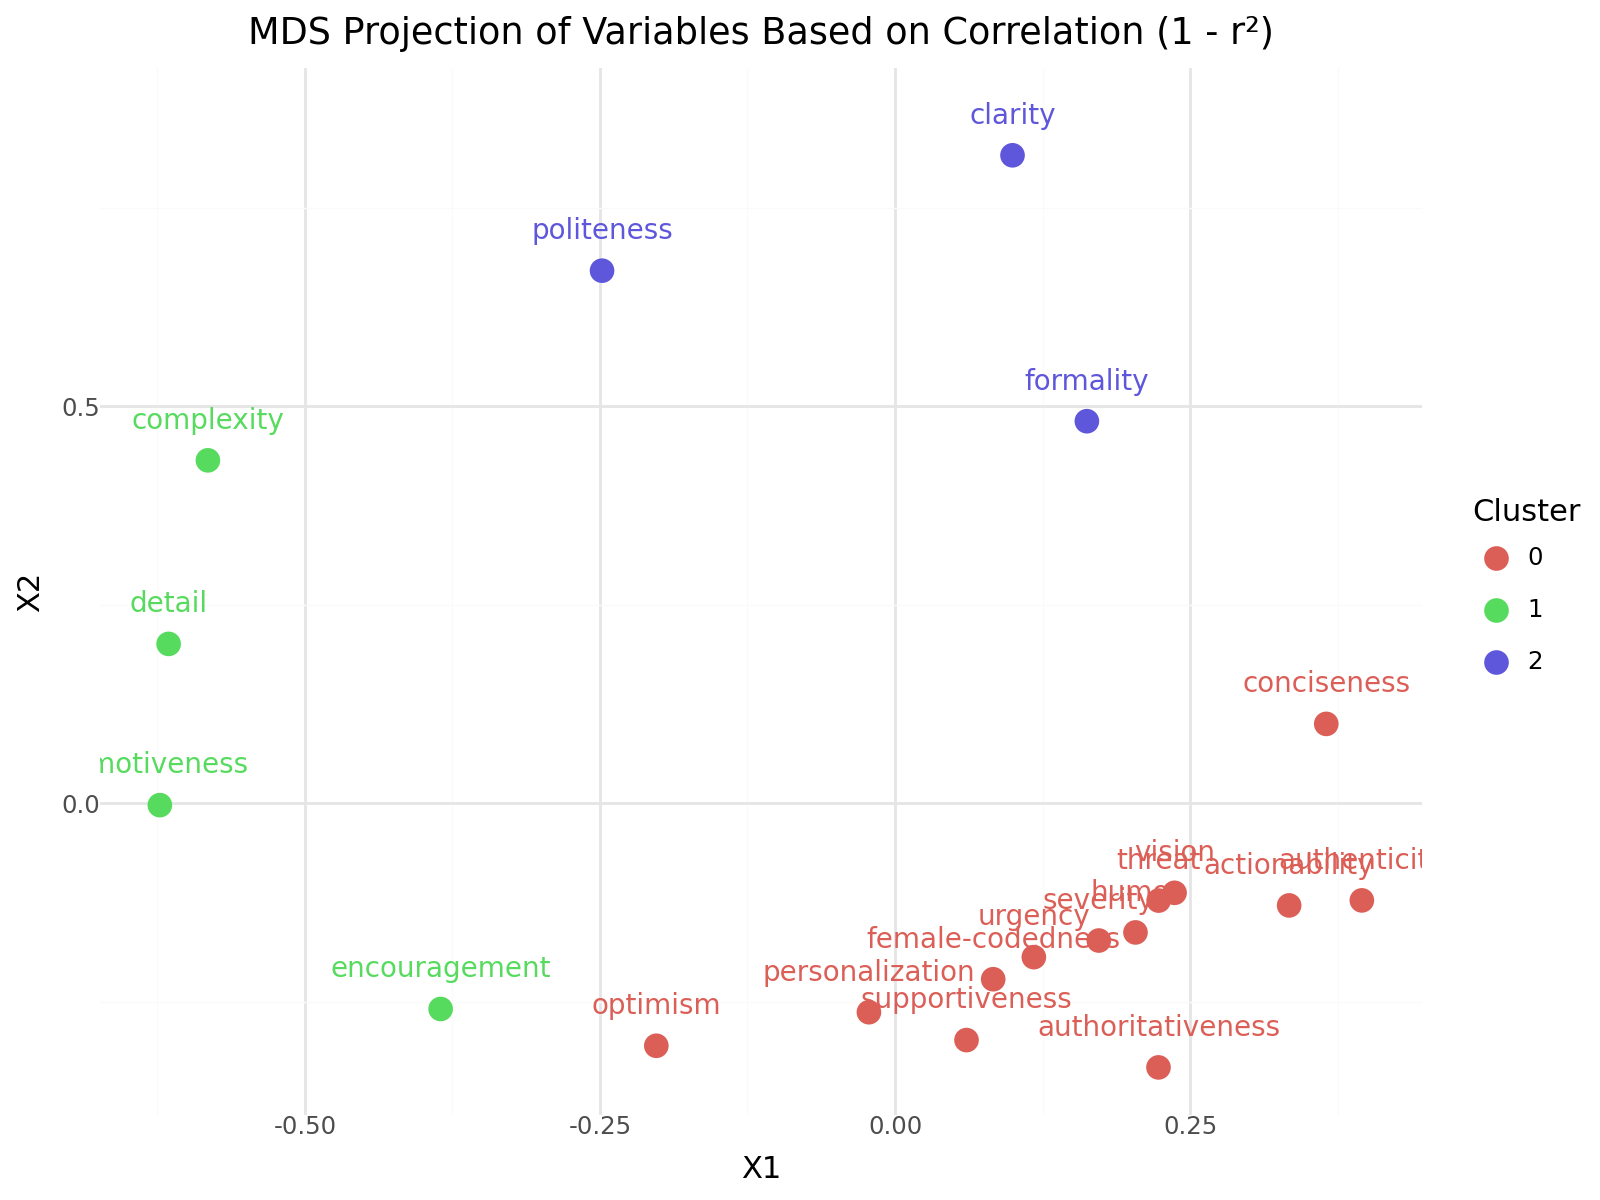

In [9]:
# Plot with plotnine
plot = (
    ggplot(plot_df, aes(x='X1', y='X2', color='Cluster', label='Style Dimension')) +
    geom_point(size=4) +
    geom_text(nudge_y=0.05, size=10, show_legend=False) +
    ggtitle('MDS Projection of Variables Based on Correlation (1 - r²)') +
    theme_minimal() +
    theme(figure_size=(8, 6))
)

plot

In [10]:
pd.DataFrame({'cluster': labels, 'dim': dims}).groupby('cluster').sample(1)['dim'].tolist()

['conciseness', 'emotiveness', 'politeness']

In [11]:
config_path = "../configs/env_setup"
agent_config_path = "../configs/agent"

In [12]:
ponats_base = open(os.path.join("../configs/agent", "ponats_linear_3comp.yaml" ) , 'r')
ponats_base = yaml.load(ponats_base, Loader=Loader)

fonats_base = open(os.path.join("../configs/agent", "fonats_linear_3comp.yaml" ) , 'r')
fonats_base = yaml.load(fonats_base, Loader=Loader)

ens_ponats_base = open(os.path.join("../configs/agent", "ensemble_sampling_3dim.yaml" ) , 'r')
ens_ponats_base = yaml.load(ens_ponats_base, Loader=Loader)

In [14]:
ens_ponats_base

{'base_config_path': './configs/agent/tuned_mlp4ensemble.yaml',
 'batch_size': 100,
 'ensemble_size': 60,
 'hidden_dimension': 64,
 'learning_rate': 0.0005,
 'num_monte_carlo_samples': 100,
 'replay_buffer_capacity': 1024,
 'type': 'poNATS-ensemble',
 'dim_batch': 'batch_1',
 'run_date': '2025-14-04'}

In [13]:
ens_ponats_base.pop('covariates')

{'formality': {'one_hot': False, 'text_based': True},
 'optimism': {'one_hot': False, 'text_based': True},
 'severity': {'one_hot': False, 'text_based': True}}

In [15]:
base_env_linear = open(os.path.join(config_path, "base_env_linear.yaml" ) , 'r')
base_env_linear = yaml.load(base_env_linear, Loader=Loader)

base_env_nn = open(os.path.join(config_path,"base_env_nn.yaml" ) , 'r')
base_env_nn = yaml.load(base_env_nn, Loader=Loader)

In [17]:
ponats_base['dim_batch']

'batch_1'

In [19]:
import copy

In [20]:
for k in [3,5,10,15]:
    # Clustering
    temp_linear = copy.deepcopy(base_env_linear)
    temp_nn = copy.deepcopy(base_env_nn)

    # Init configs for agents
    ponats_temp = copy.deepcopy(ponats_base)
    fonats_base = copy.deepcopy(fonats_base)
    ens_ponats_temp = copy.deepcopy(ens_ponats_base)

    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=base_cfg['seed'])
    labels = kmeans.fit_predict(mds_coords)

    temp_dims = pd.DataFrame({'cluster': labels, 'dim': dims}).groupby('cluster').sample(1)['dim'].tolist()
    print(temp_dims)
    temp_linear['dimensions'] = temp_dims
    temp_linear['dim_batch'] = f'{len(temp_dims)}_dim'
    temp_linear['filename'] = temp_linear['filename'] + f"_{len(temp_dims)}dims"
    temp_nn['dimensions'] = temp_dims
    temp_nn['dim_batch'] =  f'{len(temp_dims)}_dim'
    temp_nn['model_id'] = temp_nn['model_id'] + f"_{len(temp_dims)}dims"

    set_covs = [f'covariates/{dim}' for dim in temp_dims]

    ponats_temp['defaults'] = set_covs
    ponats_temp['dim_batch'] = f'{len(temp_dims)}_dim'
    fonats_base['defaults'] = set_covs
    fonats_base['dim_batch'] = f'{len(temp_dims)}_dim'
    ens_ponats_temp['defaults'] = set_covs # dim_batch
    ens_ponats_temp['dim_batch'] = f'{len(temp_dims)}_dim'

    # Saving environemnt configs 
    with open(os.path.join(config_path, f"env_linear_{len(temp_dims)}dims.yaml" ), 'w') as f:
        yaml.dump(temp_linear, f, default_flow_style=False)

    with open(os.path.join(config_path, f"env_nn_{len(temp_dims)}dims.yaml" ), 'w') as f:
        yaml.dump(temp_nn, f, default_flow_style=False)

    # Saving Agent configs 
    with open(os.path.join(agent_config_path, f"ponats_{len(temp_dims)}_dims.yaml" ), 'w') as f:
        yaml.dump(ponats_temp, f, default_flow_style=False)

    with open(os.path.join(agent_config_path, f"fonats_{len(temp_dims)}_dims.yaml" ), 'w') as f:
        yaml.dump(fonats_base, f, default_flow_style=False)

    with open(os.path.join(agent_config_path, f"ens_ponats_{len(temp_dims)}_dims.yaml" ), 'w') as f:
        yaml.dump(ens_ponats_temp, f, default_flow_style=False)

['threat', 'complexity', 'clarity']
['authenticity', 'detail', 'politeness', 'optimism', 'clarity']
['authenticity', 'detail', 'formality', 'optimism', 'complexity', 'clarity', 'personalization', 'conciseness', 'politeness', 'encouragement']
['threat', 'emotiveness', 'formality', 'optimism', 'complexity', 'clarity', 'female-codedness', 'conciseness', 'politeness', 'encouragement', 'detail', 'authoritativeness', 'actionability', 'severity', 'personalization']


In [21]:
temp_linear = copy.deepcopy(base_env_linear)
temp_nn = copy.deepcopy(base_env_nn)

temp_linear['dimensions'] = dims
temp_linear['filename'] = temp_linear['filename'] + "_full_dims"
temp_linear['dim_batch'] = 'full_dim'

temp_nn['dimensions'] = dims
temp_nn['model_id'] = temp_nn['model_id'] + "_full_dims"
temp_nn['dim_batch'] = 'full_dim'


with open(os.path.join(config_path, "env_linear_full_dims.yaml" ), 'w') as f:
    yaml.dump(temp_linear, f, default_flow_style=False)

with open(os.path.join(config_path, f"env_nn_full_dims.yaml" ), 'w') as f:
    yaml.dump(temp_nn, f, default_flow_style=False)

In [22]:
# Set full dimensional case 
# Init configs for agents
ponats_temp = copy.deepcopy(ponats_base)
fonats_base = copy.deepcopy(fonats_base)
ens_ponats_temp = copy.deepcopy(ens_ponats_base)


full_covs = [f'covariates/{dim}' for dim in dims]
ponats_temp['defaults'] = full_covs
ponats_temp['dim_batch'] = 'full_dim'
fonats_base['defaults'] = full_covs
fonats_base['dim_batch'] = 'full_dim'
ens_ponats_temp['defaults'] = full_covs
ens_ponats_temp['dim_batch'] = 'full_dim'

# Saving Agent configs 
with open(os.path.join(agent_config_path, "ponats_full_dims.yaml" ), 'w') as f:
    yaml.dump(ponats_temp, f, default_flow_style=False)

with open(os.path.join(agent_config_path, "fonats_full_dims.yaml" ), 'w') as f:
    yaml.dump(fonats_base, f, default_flow_style=False)

with open(os.path.join(agent_config_path, "ens_ponats_full_dims.yaml" ), 'w') as f:
    yaml.dump(ens_ponats_temp, f, default_flow_style=False)

In [ ]:
# Previous dims (need to check that these are the same)
['vision', 'formality', 'encouragement']
['actionability', 'complexity', 'encouragement', 'politeness', 'personalization']
['authenticity', 'complexity', 'encouragement', 'clarity', 'authoritativeness', 'politeness', 'detail', 'female-codedness', 'formality', 'severity']
['authenticity', 'complexity', 'encouragement', 'clarity', 'authoritativeness', 'politeness', 'emotiveness', 'urgency', 'formality', 'vision', 'conciseness', 'detail', 'optimism', 'personalization', 'severity']

In [15]:
dims = ['vision', 'formality', 'encouragement']
set_covs = [f'covariates/{dim}' for dim in dims]
set_covs

['covariates/vision', 'covariates/formality', 'covariates/encouragement']